command to go to mlflow ui -> mlflow ui --backend-store-uri sqlite:///mlflow.db

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import pickle

In [2]:
from urllib.request import urlretrieve

url1 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet'
urlretrieve(url1, './data/green_tripdata_2021-01.parquet')
url2 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet'
urlretrieve(url2, './data/green_tripdata_2021-02.parquet')

('./data/green_tripdata_2021-02.parquet',
 <http.client.HTTPMessage at 0x7d52be66d6a0>)

In [3]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-greentaxi-experiment')

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/3', creation_time=1727844603234, experiment_id='3', last_update_time=1727844603234, lifecycle_stage='active', name='nyc-greentaxi-experiment', tags={}>

In [4]:
# function to read parquet or CSV files, convert date columns, and compute trip duration
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    # compute trip duration in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)] # filter data to keep only trips between 1 and 60 minutes

    # convert location IDs to string format for OHE
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [6]:
len(df_train), len(df_val)

(54373, 54373)

In [7]:
# create a new feature 'PU_DO' by combining pickup and dropoff location IDs
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [8]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# using DictVectorizer to transform categorical and numerical data into vectors
dv = DictVectorizer()

# transform data into a format suitable for modeling
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [9]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(4.851821241678293)

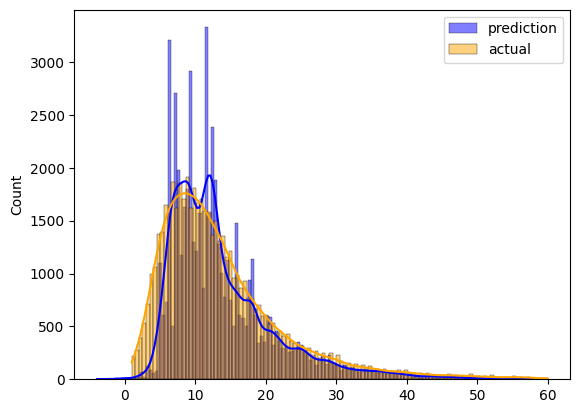

In [11]:
# Using histplot to plot predicted and actual values
sns.histplot(y_pred, label='prediction', color='blue', kde=True)  # kde=True adds a density estimate
sns.histplot(y_train, label='actual', color='orange', kde=True)
plt.legend()
plt.show()

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
with mlflow.start_run():

    mlflow.set_tag('try', '1')

    mlflow.log_param('train_data_path', './data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid_data_path', './data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

In [15]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred=booster.predict(valid)
        rmse=root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)

    return {'loss':rmse, 'status':STATUS_OK}

In [21]:
search_space={
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:30:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.15220                          
[1]	validation-rmse:6.12861                          
[2]	validation-rmse:5.59699                          
[3]	validation-rmse:5.32492                          
[4]	validation-rmse:5.18049                          
[5]	validation-rmse:5.10012                          
[6]	validation-rmse:5.05366                          
[7]	validation-rmse:5.02385                          
[8]	validation-rmse:4.99843                          
[9]	validation-rmse:4.97796                          
[10]	validation-rmse:4.96404                         
[11]	validation-rmse:4.95119                         
[12]	validation-rmse:4.94433                         
[13]	validation-rmse:4.93888                         
[14]	validation-rmse:4.93364                         
[15]	validation-rmse:4.92870                         
[16]	validation-rmse:4.91874                         
[17]	validation-rmse:4.91487                         
[18]	validation-rmse:4.91082

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:30:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.90685                                                   
[1]	validation-rmse:4.83880                                                   
[2]	validation-rmse:4.43552                                                   
[3]	validation-rmse:4.25990                                                   
[4]	validation-rmse:4.16055                                                   
[5]	validation-rmse:4.08200                                                   
[6]	validation-rmse:4.03895                                                   
[7]	validation-rmse:4.01156                                                   
[8]	validation-rmse:3.98125                                                   
[9]	validation-rmse:3.94918                                                   
[10]	validation-rmse:3.92846                                                  
[11]	validation-rmse:3.90505                                                  
[12]	validation-rmse:3.88474                        

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:31:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67398                                                    
[1]	validation-rmse:8.35398                                                    
[2]	validation-rmse:8.05967                                                    
[3]	validation-rmse:7.78950                                                    
[4]	validation-rmse:7.54169                                                    
[5]	validation-rmse:7.31472                                                    
[6]	validation-rmse:7.10744                                                    
[7]	validation-rmse:6.91837                                                    
[8]	validation-rmse:6.74617                                                    
[9]	validation-rmse:6.58967                                                    
[10]	validation-rmse:6.44728                                                   
[11]	validation-rmse:6.31850                                                   
[12]	validation-rmse:6.20178            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:33:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.18917                                                    
[1]	validation-rmse:7.52531                                                    
[2]	validation-rmse:7.00120                                                    
[3]	validation-rmse:6.59321                                                    
[4]	validation-rmse:6.27776                                                    
[5]	validation-rmse:6.03587                                                    
[6]	validation-rmse:5.85206                                                    
[7]	validation-rmse:5.71176                                                    
[8]	validation-rmse:5.60661                                                    
[9]	validation-rmse:5.52637                                                    
[10]	validation-rmse:5.46570                                                   
[11]	validation-rmse:5.41829                                                   
[12]	validation-rmse:5.38085            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:34:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.63607                                                    
[1]	validation-rmse:4.87435                                                    
[2]	validation-rmse:4.69043                                                    
[3]	validation-rmse:4.60619                                                    
[4]	validation-rmse:4.54611                                                    
[5]	validation-rmse:4.50736                                                    
[6]	validation-rmse:4.48820                                                    
[7]	validation-rmse:4.47288                                                    
[8]	validation-rmse:4.45902                                                    
[9]	validation-rmse:4.43862                                                    
[10]	validation-rmse:4.42662                                                   
[11]	validation-rmse:4.41916                                                   
[12]	validation-rmse:4.40463            

In [22]:
mlflow.xgboost.autolog(disable=True)

In [23]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.5358685902438628,
        'max_depth': 39,
        'min_child_weight': 0.9469327236310476,
        'objective': 'reg:linear',
        'reg_alpha': 0.31519642761418115,
        'reg_lambda': 0.02934036213299495,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=500,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:44:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:5.90685
[1]	validation-rmse:4.83880
[2]	validation-rmse:4.43552
[3]	validation-rmse:4.25990
[4]	validation-rmse:4.16055
[5]	validation-rmse:4.08200
[6]	validation-rmse:4.03895
[7]	validation-rmse:4.01156
[8]	validation-rmse:3.98125
[9]	validation-rmse:3.94918
[10]	validation-rmse:3.92846
[11]	validation-rmse:3.90505
[12]	validation-rmse:3.88474
[13]	validation-rmse:3.86791
[14]	validation-rmse:3.84226
[15]	validation-rmse:3.82768
[16]	validation-rmse:3.81169
[17]	validation-rmse:3.79639
[18]	validation-rmse:3.78325
[19]	validation-rmse:3.76181
[20]	validation-rmse:3.74914
[21]	validation-rmse:3.73652
[22]	validation-rmse:3.72448
[23]	validation-rmse:3.71171
[24]	validation-rmse:3.69472
[25]	validation-rmse:3.68252
[26]	validation-rmse:3.67015
[27]	validation-rmse:3.65903
[28]	validation-rmse:3.64952
[29]	validation-rmse:3.63885
[30]	validation-rmse:3.62725
[31]	validation-rmse:3.61584
[32]	validation-rmse:3.60340
[33]	validation-rmse:3.59242
[34]	validation-rmse:3.5

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:45:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/10/03 07:45:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
